# Finding Metabolic Depth in Murine Small Intestines Metabolomics data

In [1]:
import sys
import os
import random
import math
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

import multi_gaston
from multi_gaston import data_processing, multi_gaston, process_NN_output

## Step 1: Pre-processing

The data input for MET-MAP(Multi-GASTON) should contain: 
- N x 2 spatial coordinate matrix,
- N x 1 total ion count,
- N x M metabolite abundance matrix
- list of metabolite names

where N=number of spatial locations and M=number of metabolites.

For murine intestine data, the input only contains epithelial pixels filtered out by k-means clustering, and we will perform TIC normalization and log-transform on the input.

In [2]:
!mkdir -p m153_07

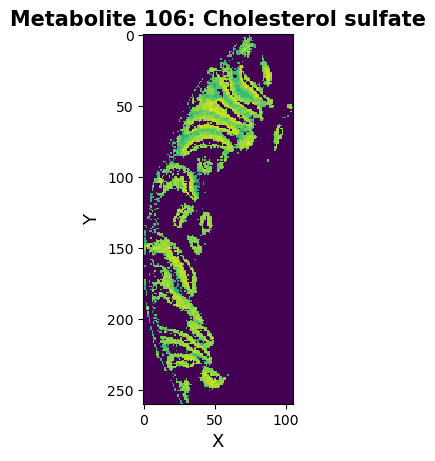

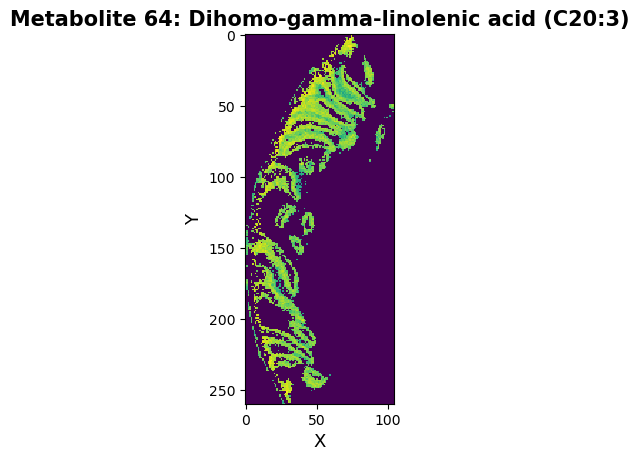

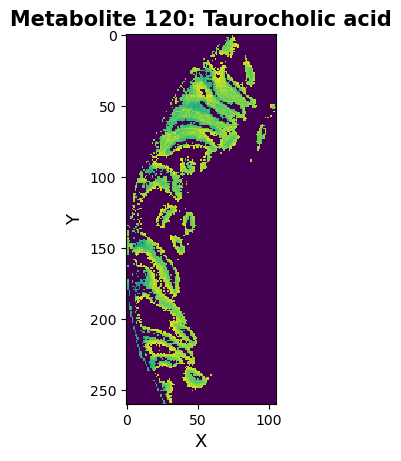

In [3]:
# load the metabolite names
names = pd.read_excel('meta_list.xlsx',header=0).to_numpy()

# data: first 2 columns are 2D coordinates, 3rd column TIC, remaining columns are raw abundance
data_dir = '153_07.csv'
save_dir = 'm153_07'
X,Y,S,A = data_processing.process(data_dir)
data = np.hstack((S,A))

# plot the some marker metabolites abundance to visualize the tissue
c20_id = np.where(names[:,0]=='Dihomo-gamma-linolenic acid (C20:3)')[0][0]
cho_id = np.where(names[:,0]=='Cholesterol sulfate')[0][0]
tau_id = np.where(names[:,0]=='Taurocholic acid')[0][0]
data_processing.plot_mat(data,cho_id,names[:,0])
data_processing.plot_mat(data,c20_id,names[:,0])
data_processing.plot_mat(data,tau_id,names[:,0])

np.savetxt(save_dir + f'/{save_dir}_processed.csv',data, delimiter=",")

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 10 different times, each with a different seed. 

### Option 1: train in notebook

We first transform the input matrices into torch tensors and z-score normalize.

In [4]:
# N x M feature matrix A and N x 2 coordinate matrix S are outputs from Step 1
S_torch, A_torch = data_processing.tensor_transform_inputs(S,A)

Next we train the neural network, once for each random initialization. 

In [6]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, e.g. [20,20] means two hidden layers of size 20 hidden neurons
met_dep_arch=[120,120] # architecture for metabolic depth neural network d(x,y) : R^2 -> R^K 
K=3 # number of metabolic depths to learn
lasso_coefficients = [0.0001,0.00025,0.00075,0.001,0.01]

num_epochs = 30000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 5000 # save model after number of epochs = multiple of checkpoint
out_dir = save_dir # folder to save model runs
optimizer = "adam"
num_restarts = 5

######################################

seed_list=range(num_restarts)
for lasso in lasso_coefficients:
    print(f'training neural network for lasso = {lasso}')
    for seed in seed_list:
        print(f'\tseed = {seed}')
        out_dir_seed=f"{out_dir}/lasso{lasso}/rep{seed}/"
        os.makedirs(out_dir_seed, exist_ok=True)
        mod, loss_list, lasso_loss = multi_gaston.train(S_torch, A_torch,
                              S_hidden_list=met_dep_arch, A_hidden_list=[],
                              A_linear=True, lasso_lambda=lasso, K = K,
                              epochs=num_epochs, checkpoint=checkpoint, 
                              SAVE_PATH=out_dir_seed, optim=optimizer, seed=seed)

training neural network for lasso = 0.0001
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4
training neural network for lasso = 0.00025
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4
training neural network for lasso = 0.00075
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4
training neural network for lasso = 0.001
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4
training neural network for lasso = 0.01
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4


## Step 3: Process neural network output

If you use the model trained above, then figures will closely match the manuscript --- but not exactly match --- due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ). 

We also include the model used in the paper for reproducibility.

### Visualize metabolic depth (isodepth) and spatial domains

We first plot the metabolic depth from each trial, which will assist with selecting the best trial. To match with the results and plots used in the paper, we load the best metabolic depth.

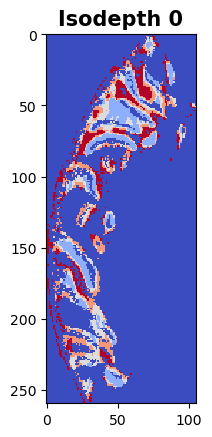

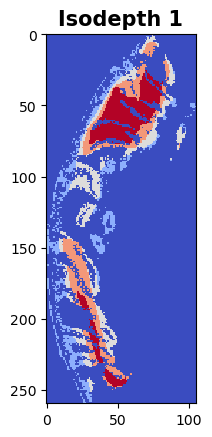

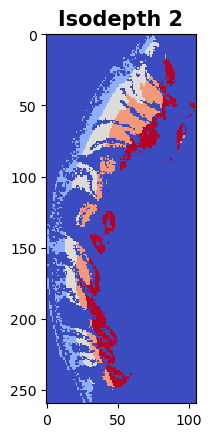

In [7]:
# May need to reload the input data
data = pd.read_csv(save_dir+f'/{save_dir}_processed.csv',header=None).to_numpy()
S,A=data[:,:2],data[:,2:]

# MODEL TRAINED ABOVE
for lasso in lasso_coefficients:
    out_dir = save_dir+f'/lasso{lasso}/isodepths_all_trials'
    os.makedirs(  out_dir, exist_ok=True)
    for seed in range(num_restarts):
        out_dir_seed=save_dir+f'/lasso{lasso}/rep{seed}/'
        process_NN_output.plot_trials_multi(out_dir_seed,out_dir,S,seed)
# isodepth = np.loadtxt(=f"{save_dir}/lasso{best_lasso}/rep{best_seed}/isodepth.txt")

# TO MATCH PAPER FIGURES
isodepth = np.loadtxt(f"paper_results/153_07_loss0.87587_exp0.86354_nhs120,120_nhalin_trial4_lasso0.001_isodepth.txt")
process_NN_output.plot_isodepth(isodepth, S, show_plot=True, percentile_plot=True)

Through visual assessment, we can clearly identify that isodepth 2 describes the crypt-villus axis, while isodepth 0 approximates the interior-to-brush-border axis. We scale the crypt-villus metabolic depth, make sure the minimum depth corresponds to the crypt area. 

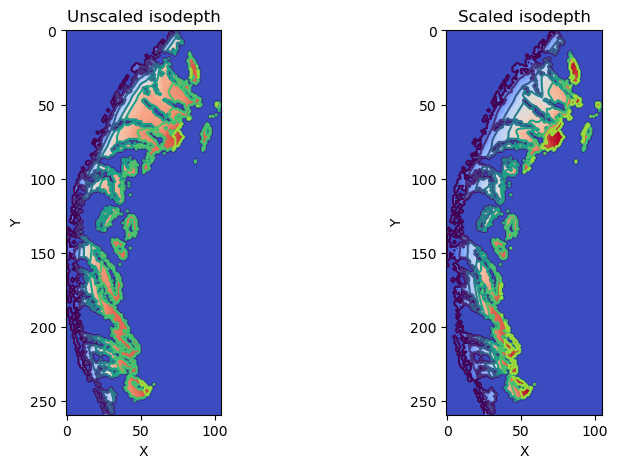

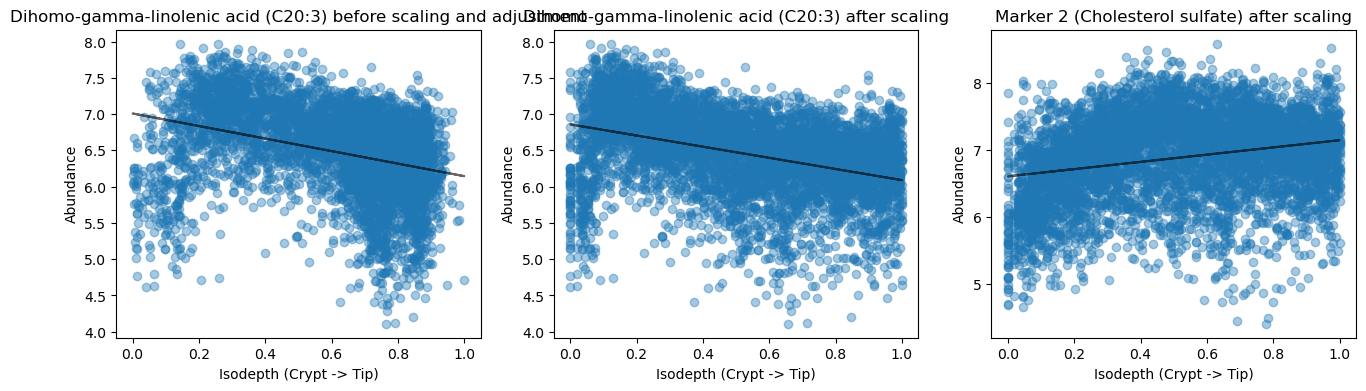

In [8]:
# Scale the isodepth, users may change the number of bins scale_n
scaled_isodepth = process_NN_output.adjust_isodepth(data, isodepth[:,2], names, c20_id,cho_id,show_plot=True, scale_n = 200, axis_name='(Crypt -> Tip)')
crop_w_isodepth = np.insert(data, 2, scaled_isodepth, axis=1)
np.savetxt(save_dir+'/m153_07_finalisodepth.csv',crop_w_isodepth, delimiter=",")

OPTIONAL: The interior-to-brush-border metabolic depth is not used in the paper, but here we scale it against Cholesterol sulfate, which is more abundant closer to the interior of the villus. In contrast, plotting the interior-to-brush-border metabolic depth against Taurocholic acid, we see a clear positive correlation.

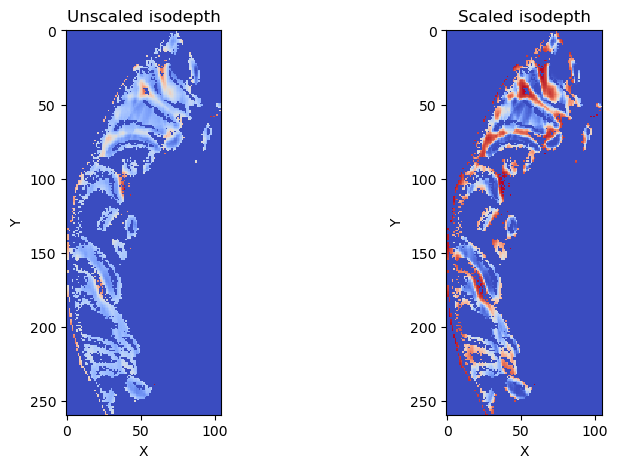

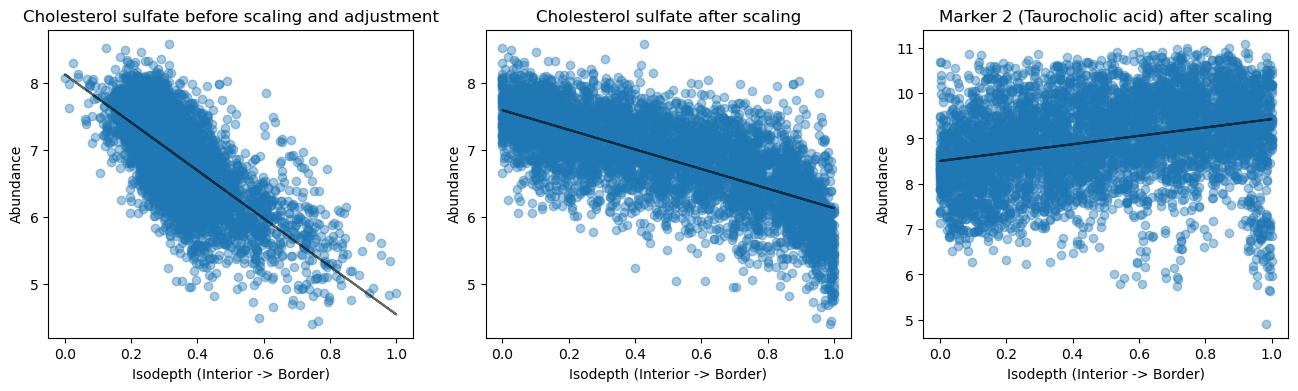

In [9]:
scaled_isodepth1 = process_NN_output.adjust_isodepth(data, isodepth[:,0], names,cho_id, tau_id,show_plot=True, scale_n = 200, axis_name='(Interior -> Border)', contour_plot=False)